In [249]:
import os
import pandas as pd
import time
#import pymagnitude 
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem.porter import PorterStemmer


In [250]:
# if necesseray install the Natural Language Toolkit (NLTK) in Python
!pip install nltk


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [251]:
%pip install gensim
#install POT and pyemd necessary to use the Gensim's WMD implementation 
#(Python Optimal Transport library)
%pip install POT
#(Python Earth Mover's Distance library)
%pip install pyemd 


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [255]:
! pwd
#!cd c:\Users\anaele.baudant\'OneDrive - BEFIVE'

'pwd' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [187]:
#BUG
#from features import load_data, preprocess_dataset

In [226]:
#reprise des fonctions load_data preprocess_sentence et preprocess_dataset

def load_data():
    data = dict()
    #for fn in os.listdir("stsbenchmark"):
    for fn in os.listdir("stsbenchmark"):
        if fn.endswith(".csv"):
            with open("stsbenchmark/" + fn,encoding='utf-8') as f:
                subset = fn[:-4].split("-")[1]
                #logger.info(f"subset: %s", subset)
                data[subset] = dict()
                data[subset]['data'] = []
                data[subset]['scores'] = []
                for l in f:
                    # genre filename year score sentence1 sentence2 (and sources, sometimes)
                    l = l.strip().split("\t")
                    data[subset]['data'].append((l[5], l[6]))
                    data[subset]['scores'].append(float(l[4]))
    return data

def preprocess_sentence(sentence):
    stemmer = PorterStemmer()
    # tokenize and lower case
    tokens = word_tokenize(sentence.lower())
    # stemming and removing stop words
    stemmed_tokens = [stemmer.stem(token) for token in tokens if not token in set(
        stopwords.words('english'))]
    # remove punctuations
    filtered_tokens = [
        token for token in stemmed_tokens if token not in punctuation]
    # return ' '.join(filtered_tokens) # Anaele supprimé ici et intégré dans preprocess_dataset()
    return filtered_tokens  # renvoie une liste (vecteur de la phrase)

def preprocess_dataset(dataset):
    df = pd.DataFrame(dataset)

    df[['s1', 's2']] = df['data'].apply(lambda x: pd.Series(x))
    df['sm'] = df['s1'] + " " + df['s2']  # merged sentences
    # preprocessing des phrases 1 et 2 en vecteur ou string :
    df['token_1'] = df['s1'].apply(preprocess_sentence)  # vecteur
    df['token_2'] = df['s2'].apply(preprocess_sentence)  # vecteur
    df['token_m'] = df['sm'].apply(preprocess_sentence)  # vecteur
    df['s1_pp'] = df['token_1'].apply(' '.join)  # string
    df['s2_pp'] = df['token_2'].apply(' '.join)  # string
    df['sm_pp'] = df['token_m'].apply(' '.join)  # string
    df['scores_norm'] = df['scores'] / 5  # normalisation du score entre 0 et 1
    # Replace empty strings with NaN
    df.replace('', np.nan, inplace=True)

    # Store the index labels before dropna
    index_before_dropna = df.index

    # Drop rows with NaN values
    df.dropna(inplace=True)

    df.reset_index(drop=True)

    # Store the index labels after dropna
    index_after_dropna = df.index

    # Get the index labels that were dropped
    dropped_indexes = index_before_dropna.difference(index_after_dropna)

    return df


In [ ]:
#chargement de la base de donnée
dataset=load_data()
df_dev = pd.DataFrame(dataset['dev'])
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_train.head()

In [256]:
#Exploration des données :
#print('structure de dataset:',dataset.keys())
#print('structure de data[\'test\']:',dataset['test'].keys())
#print('structure de df_test:',df_test.keys())

In [306]:
#pre-processing
df_dev_pp = preprocess_dataset(df_dev)
df_train_pp = preprocess_dataset(df_train)
df_test_pp = preprocess_dataset(df_test)

In [77]:
#cd c:\Users\anaele.baudant\GoogleNews-vectors-negative300
#%cd c:\Users\anaele.baudant\GoogleNews-vectors-negative300
#%pwd

In [174]:
#MODEL KeyedVerctors de Word2vec (extension .bin)
# à partir du fichier à télécharger préalablement: GoogleNews-vectors-negative300.bin
# https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
# !!! ficher fait 1,5 GB compressé et 3,6 GB décompressé !!!

from gensim.models import KeyedVectors

#path = 'c:\Users\anaele.baudant\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin\'
file='GoogleNews-vectors-negative300.bin'

# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format(file, binary=True)   

def remove_OOV(text):
    '''removes words in sentence that is not found in the vocabulary
    OOV=out of vocabulary'''
    return [word for word in doc if word in model.key_to_index]


In [307]:
#illustration du modele KeyedVectors
dog = model['dog']
cat = model['cat']
dogs = model['dogs']

print("6 premieres valeurs des vecteurs (de dimension",dog.shape[0],')')
print('dog',dog[:6])
print('dogs',dogs[:6])
print('cat',cat[:6])

# calcul de la distance avec wmdistance (Word Mover's Distance (WMD))
#distance sur R+ / si résultat = inf (infiny) il y a une erreur (word out of vocabulary ou pb format)
distance1 = model.wmdistance('cat', 'dog')
distance2 = model.wmdistance('dog', 'dogs')
distance3 = model.wmdistance('dog', 'philosophy')

print('\ndistance cat dog:',distance1)
print('distance dog dogs:',distance2)
print('distance dog philosophy:',distance3)

6 premieres valeurs des vecteurs (de dimension 300 )
dog [ 0.05126953 -0.02233887 -0.17285156  0.16113281 -0.08447266  0.05737305]
dogs [-0.02050781 -0.01245117 -0.12792969  0.21777344 -0.140625    0.02612305]
cat [ 0.0123291   0.20410156 -0.28515625  0.21679688  0.11816406  0.08300781]

distance cat dog: 1.0106912030917452
distance dog dogs: 0.29174261808811397
distance dog philosophy: 0.7649682443081849


In [309]:
#test word out of vocabulary
doc1 =['cat','on','table','dflkjdsqlkmfjdsfdlk']
#doc1=['plane', 'take']
doc2 = [word for word in doc1 if word in model.key_to_index]
print('doc1 :',doc1,'\ndoc2 :',doc2)
print('distance doc1 - doc2:',model.wmdistance(doc1, doc2))
s1 =['cat on table dflkjdsqlkmfjdsfdlk']
s2 =['cat on table dflkjdsqlkmfjdsfdlk']
print('s1 :',s1,'\ns2 :',s2)
print('distance s1 - s2:',model.wmdistance(s1, s2))

doc1 : ['cat', 'on', 'table', 'dflkjdsqlkmfjdsfdlk'] 
doc2 : ['cat', 'on', 'table']
distance doc1 - doc2: 0.0
s1 : ['cat on table dflkjdsqlkmfjdsfdlk'] 
s2 : ['cat on table dflkjdsqlkmfjdsfdlk']
distance s1 - s2: inf


In [314]:
df_train_pp.iloc[:,0].head()
type((df_train_pp.iloc[:,0][0])[0])

str

In [318]:
df_train_pp.shape[0]

1000

In [359]:
def WMD_score(df,s1,s2,m=1):
    """Calcule la distance WMD et les scores associé entre les phrases de 2 colonnes
    Attributes:
        df: The pandas dataframe
        s1: The label of the first sentence (can be a string  or list of strings)
        s2: The label of the second sentence (can be a string  or list of strings)
        m: coefficient for the exponential score
    """
    for i in range(df.shape[0]):

        s1v=df[s1].iloc[i]
        s2v=df[s2].iloc[i]
        #retire les mots pas dans le vocabulaire
        s1v=[word for word in s1v if word in model.key_to_index]
        s2v=[word for word in s2v if word in model.key_to_index]
        #calcule distance WMD
        distance_wmd=model.wmdistance(s1v,s2v)
        df.loc[i, 'distance_WMD'] = distance_wmd
        #transformation distance en score normalisé (entre 0 et 1)
        df.loc[i, 'scores_WMD_exp'] = 1-distance_wmd
        df.loc[i, 'scores_WMD_inv'] = np.exp(-distance_wmd*m)
    df['scores_WMD_max'] = 1-df['distance_WMD']/df['distance_WMD'].max()
    return df

def WMD_score_str(df,m=1):
    '''Calcule la distance WMD et les scores associé entre deux phrases dans un tupple (dataset non processé)'''
    for i in range(df.shape[0]):
        #retire les mots pas dans le vocabulaire
        s=df.iloc[i,0]
        s1v=s[0]
        s2v=s[1]
        #s1v=[word for word in s1v if word in model.key_to_index]
        #s2v=[word for word in s2v if word in model.key_to_index]
        #calcule distance et scores associés
        distance_wmd=model.wmdistance(s1v,s2v)
        df.loc[i, 'distance_WMD'] = distance_wmd
        df.loc[i, 'scores_WMD_exp'] = 1-distance_wmd
        df.loc[i, 'scores_WMD_inv'] = np.exp(-distance_wmd*m)
    df['scores_WMD_max'] = 1-df['scores_WMD']/df['scores_WMD'].max()
    return df

In [358]:
#WMD score on non-pre-processed data
WMD_score_str(df_train)
#WMD_score2(df_train_pp,'token_1','token_2')
#WMD_score(df_train_pp,'token_1','token_2')
df_train[['s1','s2','scores_init','distance_WMD','scores_WMD_exp','scores_WMD_max']].head()

,s1,s2,scores_init,distance_WMD,scores_WMD_exp,scores_WMD_max
0,A plane is taking off.,An air plane is taking off.,1.00,0.127236,0.872764,0.795718
1,A man is playing a large flute.,A man is playing a flute.,0.76,0.159812,0.840188,0.743417
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,0.160854,0.839146,0.741744
3,Three men are playing chess.,Two men are playing chess.,0.52,0.173660,0.826340,0.721184
4,A man is playing the cello.,A man seated is playing the cello.,0.85,0.180407,0.819593,0.710352


In [360]:
#####################################################
# 1. WMD score on non-pre-processed data (strings)  #
#####################################################
WMD_score(df_train_pp,'s1','s2')
#WMD_score(df_train_pp,'token_1','token_2')
df_train_pp[['s1','s2','scores_init','distance_WMD','scores_WMD_exp','scores_WMD_max']].head()

,s1,s2,scores_init,distance_WMD,scores_WMD_exp,scores_WMD_max
0,A plane is taking off.,An air plane is taking off.,1.00,0.127236,0.872764,0.795718
1,A man is playing a large flute.,A man is playing a flute.,0.76,0.159812,0.840188,0.743417
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,0.160854,0.839146,0.741744
3,Three men are playing chess.,Two men are playing chess.,0.52,0.173660,0.826340,0.721184
4,A man is playing the cello.,A man seated is playing the cello.,0.85,0.180407,0.819593,0.710352


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

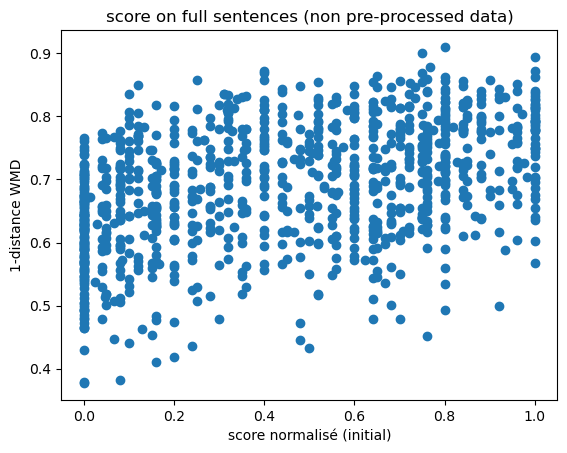

In [352]:
# score initial (x) et 1-score_pwd (y) NON PREPROCESSED
plt.scatter(df_train_pp['scores_init'],1-df_train_pp['distance_WMD'])#),'.',color='red')
#plt.scatter(df_train['scores_init'],df_train['scores_WMD_exp'])
plt.xlabel('score normalisé (initial)',fontsize=10)
plt.ylabel('1-distance WMD',fontsize=10)
plt.title('score on full sentences (non pre-processed data)')
plt.plot

In [354]:
##################################################
# 2. WMD score on pre-processed data (vecteurs)  #
##################################################
WMD_score(df_train_pp,'token_1','token_2')
df_train_pp[['token_1','token_2','scores_norm','distance_WMD','scores_WMD_exp','scores_WMD_max']].head()

,token_1,token_2,scores_norm,distance_WMD,scores_WMD_exp,scores_WMD_max
0,"[plane, take]","[air, plane, take]",1.00,0.417267,0.582733,1.0
1,"[man, play, larg, flute]","[man, play, flute]",0.76,0.338564,0.661436,1.0
2,"[man, spread, shrede, chees, pizza]","[man, spread, shred, chees, uncook, pizza]",0.76,0.334131,0.665869,1.0
3,"[three, men, play, chess]","[two, men, play, chess]",0.52,0.094085,0.905915,1.0
4,"[man, play, cello]","[man, seat, play, cello]",0.85,0.338632,0.661368,1.0


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

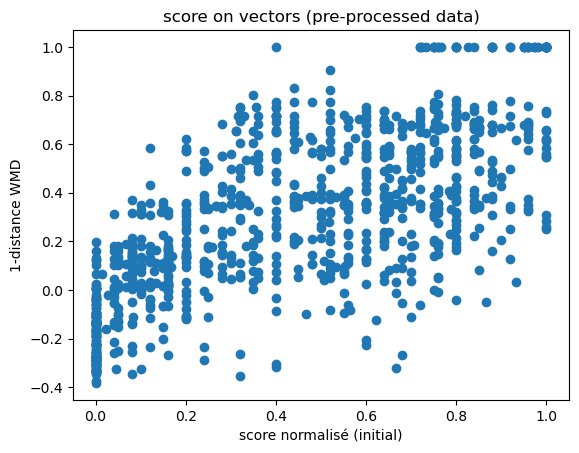

In [355]:
# score initial (x) et 1-score_pwd (y) NON PREPROCESSED
plt.scatter(df_train_pp['scores_init'],1-df_train_pp['distance_WMD'])#),'.',color='red')
#plt.scatter(df_train['scores_init'],df_train['scores_WMD_exp'])
plt.xlabel('score normalisé (initial)',fontsize=10)
plt.ylabel('1-distance WMD',fontsize=10)
plt.title('score on vectors (pre-processed data)')
plt.plot

In [246]:
#MODEL Magnitude de Word2vec (extension .magnitude)
# à partir du fichier à télécharger préalablement: GoogleNews-vectors-negative300.bin
# http://magnitude.plasticity.ai/word2vec/medium/GoogleNews-vectors-negative300.magnitude
# !!! fichier fait 4,9 Go !!!

#### How pymagnitude works
from pymagnitude import *

# Loading vectors
## TO COMPLETE : specify the path to the magnitude file in ""
# magnitude file to download from word2vec
file='GoogleNews-vectors-negative300.magnitude'
vectors = Magnitude(path)

# This is how you obtain the vector for a word (for example, "cat"):
cat_vector = vectors.query("cat")

ModuleNotFoundError: No module named 'annoy'

In [146]:
# Install the Pymagnitude word embedding library
# !!! this may take some time (around 5 minutes) !!!
t=time.time()
! pip install pymagnitude
print('\ntemps de telechargement de pymagnitude (en seconde):',round(time.time()-t,6),'s')

DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
ERROR: You must give at least one requirement to install (see "pip help install")


  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for annoy
Failed to build annoy

temps de telechargement de pymagnitude (en seconde): 14.974116 s


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [22 lines of output]
  C:\Users\anaele.baudant\anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running bdist_wheel
  running build
  running build_py
  creating buil

In [148]:
! pip install --use-pep517
! pip install annoy

ERROR: You must give at least one requirement to install (see "pip help install")


  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for annoy
Failed to build annoy


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [22 lines of output]
  C:\Users\anaele.baudant\anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running bdist_wheel
  running build
  running build_py
  creating buil